In [1]:
import numpy as np
# using the widget backend on matplotlib requires installing ipympl
%matplotlib widget
import matplotlib.pyplot as plt

# Defining the example function
We will start this TP working on a simple example cost function that does not depend on data. Later we will work on the least-squares linear regression cost, seen during the last exercise class.

Here is the definition of the example cost and its gradient:

In [2]:
from numpy.typing import ArrayLike

def function(theta: ArrayLike) -> float:
    """A test function
    f(x,y) = 4y e^(-x^2 - y^2) 
        Args:
        theta (ArrayLike): point at which gradient is computed
    Returns:
        (float): function value at given point
    """
    x,y = theta[0], theta[1] 
    return 4*y*np.exp(- x**2 - y**2)

def gradient(theta: ArrayLike) -> ArrayLike:
    """Gradient for the test function
    df/dx = -8 e^(-x^2 - y^2) x y
    df/dy = e^(-x^2 - y^2) (4 - 8 y^2)

    Args:
        theta (ArrayLike): point at which gradient is computed
    Returns:
        grad (ArrayLike): gradient vector (same shape as theta)
    """
    x,y = theta[0],theta[1]
    x2 = x**2
    y2 = y**2
    exp_term = np.exp(- x2 - y2)
    dfdx = -8*x*y*exp_term
    dfdy = (4-8*y2)*exp_term
    grad = np.array([dfdx, dfdy])
    return grad

minimum = np.array([0,-1/np.sqrt(2)])
minimum_f_val = function(minimum)

This is a function to plot the contours of the mathematical function defined above:

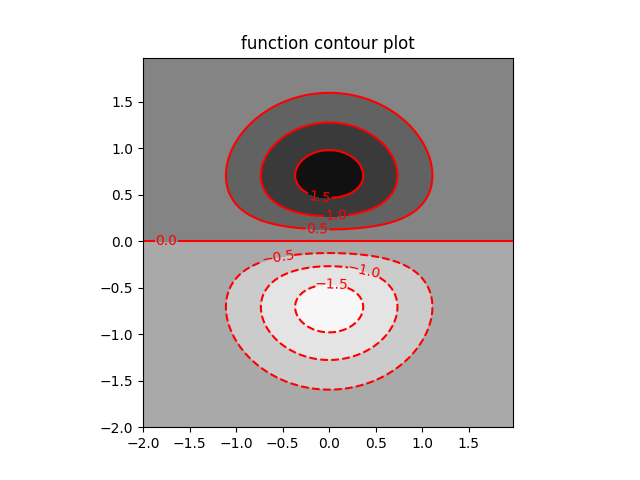

In [3]:
def plot_function(func):
    delta = 0.025
    x = np.arange(-2.0, 2.0, delta)
    y = np.arange(-2.0, 2.0, delta)
    X, Y = np.meshgrid(x, y)
    Z = func((X,Y))

    ax = plt.gca()
    ax.contourf(X,Y,Z, cmap='Greys')
    CS = ax.contour(X, Y, Z, colors='r')
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title('function contour plot')
    ax.axis('square')

plt.close(1)
plt.figure(1)
plot_function(function)
plt.show()

# Exercise 1 - using optimizers from scipy
In this exercise you will use the generic minization solver from `scipy`: 
[`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)


More specificaly, you will use the following method: 
[`scipy.optimize.minimize(method='BFGS')`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html)


## Calling the solver

**TODO**: Complete the function call to include:  
- the choice of method as being BFGS
- the example function as the cost to be minimized
- the previously defined gradient function so `minimize` knows how to compute it
- the initial point [1.5, -1.5]
- the maximum number of iterations (use 100)
- the tolerance to considering that the gradient has reached zero (use 1e-6)
- tell the method to return all intermediate parameter values (so that we can plot the optimization path later)

You should find keyword argument names on scipy documentation.

In [10]:
import scipy as sp
from scipy.optimize import minimize

initial_point = np.array([1.5, -1.5])
max_iterations = 100
tolerance = 1e-6

out = minimize(
    function,
    initial_point,
    method='BFGS',
    jac=gradient,
    options={
        'maxiter': max_iterations,
        'gtol': tolerance,
        'disp': True,
        'return_all':True
    }
)
out

Optimization terminated successfully.
         Current function value: -1.715528
         Iterations: 8
         Function evaluations: 16
         Gradient evaluations: 16


  allvecs: [array([ 1.5, -1.5]), array([ 0.30407438, -0.56983563]), array([ 0.24965144, -0.5335559 ]), array([ 0.20639524, -0.56151225]), array([ 0.10761775, -0.62046679]), array([-0.01610928, -0.70796043]), array([ 3.86375113e-04, -7.07143560e-01]), array([ 1.18256272e-07, -7.07108938e-01]), array([-1.40107848e-08, -7.07106859e-01])]
      fun: -1.7155277699213922
 hess_inv: array([[ 0.29128502, -0.00095126],
       [-0.00095126,  0.14042531]])
      jac: array([-4.80717808e-08, -5.35938182e-07])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 8
     njev: 16
   status: 0
  success: True
        x: array([-1.40107848e-08, -7.07106859e-01])

## Learning curves

When doing numerical optimization, a useful way of visualizing the optimization progress is through following the cost function value across iterations. In machine learning, these cost vs iteration curves are called leraning curves. Here is a function allowing to plot this curve, as well as the evolution of the gradient across iterations.

In [6]:
def plot_learning_curves(cost_curve, grad_curve,val_curve=None,
                         optimal_cost=None, smooth=None):
    # define x axis for plots
    iters = np.arange(0,len(cost_curve))
    # compute gradient norms to plot
    grad_norms = np.apply_along_axis(np.linalg.norm, axis=1, arr=grad_curve)
    # smooth curves with a moving average if needed
    if smooth is not None:
        window_width = int(smooth * len(cost_curve))
        iters = iters[window_width-1:]
        def moving_average(data):
            cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
            ma_vec = ((cumsum_vec[window_width:] - cumsum_vec[:-window_width]) 
                      / window_width)
            return ma_vec
        cost_curve = moving_average(cost_curve)
        grad_norms = moving_average(grad_norms)
        if val_curve is not None:
            val_curve = moving_average(val_curve)

    ax = plt.gca()
    ax.set_title('Learning curves')
    ax.set_xlabel('iterations')
    ax.set_ylabel('cost value')
    ax.plot(iters, cost_curve, '+:', label='cost')
    if val_curve is not None:
        ax.plot(iters, val_curve, '+:', label='validation cost')
    ax2 = ax.twinx()
    ax2.plot(iters, grad_norms, '+:', label='grad. norm', color='C7')
    ax2.set_ylabel('gradient norm')
    if not optimal_cost is None:
        xmin, xmax = ax.get_xlim()
        ax.hlines(optimal_cost, xmin, xmax, color='k', label='optimal cost')
    plt.gcf().legend()
    return ax, ax2

Now let's apply this function to the evolution the solver we just called:

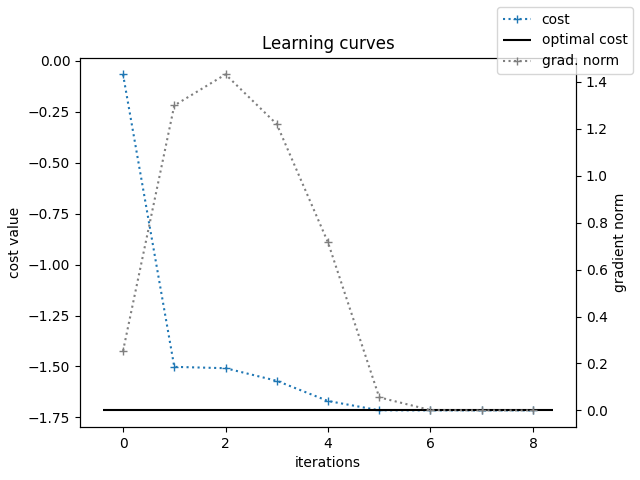

In [15]:
cost_curve = list(map(function, out['allvecs']))
grad_curve = list(map(gradient, out['allvecs']))

plt.close(2)
plt.figure(2)
plot_learning_curves(cost_curve, grad_curve, optimal_cost=minimum_f_val)
plt.show()

## Optimization path
Since we have a function over a 2D space, we can visualize the optimization path over the contour plot of the function. Here is a function to do just that:

In [12]:
def plot_optim_path(optim_path):
    ax = plt.gca()
    ax.plot (*np.array(optim_path).T, color='orange', lw=1, label='optim. path')
    for i, x in enumerate(optim_path[:-1]):
        dx, dy = optim_path[i+1] - x
        size = np.sqrt(dx**2 + dy**2)
        ax.arrow(*x, dx, dy, shape='full', lw=0, 
        head_width=0.05*size, 
        head_length=0.1*size, 
        length_includes_head=True, color='orange')
    ax.legend()

Now applying the function to our case:

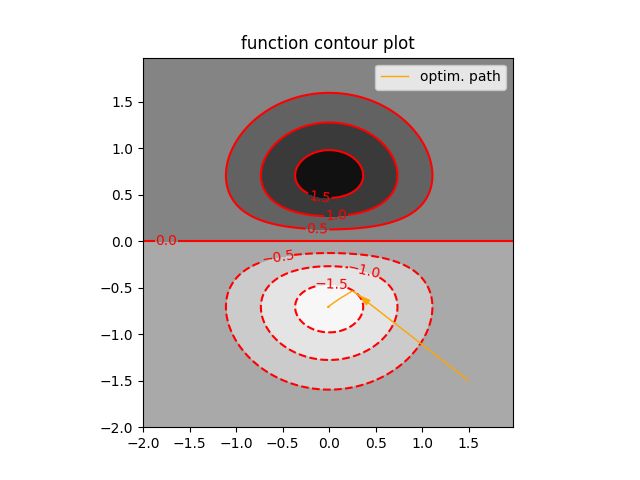

In [13]:
plt.close(3)
plt.figure(3)
plot_function(function)
plot_optim_path(out['allvecs'])
plt.show()

# Exercise 2 - coding a generic GD minimizer

Now you are going to code your own gradient descent solver. A class template is provided below, but some blank spaces remain to be completed.

## Defining the solver
**TODO**: Study the class `GDminimizer` proposed bellow and complete the code where indicated by a TODO tag.

In [16]:
from typing import Callable, Iterable
from copy import copy


class GDminimizer():
    def __init__(self, keep_history=True):
        self._keep_history = keep_history
        self.history = dict(theta=[], cost=[], grad=[], n_iter=0)
        self._func = None
        self._grad = None
        self._n_iter = 0
        self._last_cost = 0
        self._last_grad = 0
        self._last_th = None

    @property
    def state(self):
        """property allowing access to internal state dict"""
        return dict(theta=self._last_th, cost=self._last_cost, grad=self._last_grad, n_iter=self._n_iter)

    def step(self, func: Callable, grad: Callable, theta0: ArrayLike,
             step_size=1e-4, warm_start=False):
        """Takes one GD step

        Args:
            func (Callable): cost function taking one argument (theta)
            grad (Callable): gradient function taking one argument (theta)
            theta0 (ArrayLike): initial state for the theta parameter (ignored if warm_start is True)
            step_size (float, optional): fraction of gradient taken as a step. Defaults to 1e-4.
            warm_start (bool, optional): if True, continues optimization from current internal state. Defaults to False.

        Returns:
            state: dictionnary containing current solver state
        """
        # initialize internal state variables
        self._initialize(func, grad, theta0, warm_start)
        # then compute and apply gradient step,
        # updating internal state variables
        self._apply_step(step_size)
        return self.state

    def minimize(self, func: Callable, grad: Callable, theta0: ArrayLike,
                 step_size=1e-4, warm_start=False, max_iter=100, tol=1e-6):
        """Takes repeated GD steps until a convergence criterium is reached

        Args:
            func (Callable): cost function taking one argument (theta)
            grad (Callable): gradient function taking one argument (theta)
            theta0 (ArrayLike): initial state for the theta parameter (ignored if warm_start is True)
            step_size (float, optional): fraction of gradient taken as a step. Defaults to 1e-4.
            warm_start (bool, optional): if True, continues optimization from current internal state. Defaults to False.
            max_iter (int, optional): [description]. Defaults to 100.
            tol (float, optional): [description]. Defaults to 1e-6.

        Returns:
            state: dictionnary containing current solver state
        """
        # initialize internal state variables
        self._initialize(func, grad, theta0, warm_start)
        # then compute and apply gradient step,
        # updating internal state variables
        # repeating until max iter or convergence is reached
        # TODO complete the while condition
        while (self._n_iter < max_iter):
            self._apply_step(step_size)
            # check convergence condition
            # TODO complete the convegence condition check
            if (np.linalg.norm(self._last_grad) < tol):
                break
        return self.state

    def _compute_step(self, step_size):
        """Auxiliary function to compute a GD step given a step_size"""
        # TODO modify the function to return the GD step
        return step_size * self._last_grad

    def _apply_step(self, step_size):
        """Auxiliary function to apply a gradient step updating internal state values"""
        # update theta, grad and cost value
        self._last_th -= self._compute_step(step_size)
        self._last_cost = self._func(self._last_th)
        self._last_grad = self._grad(self._last_th)
        if self._keep_history:
            self._update_history(self.state)
        self._n_iter += 1
        return self.state

    def _update_history(self, state):
        for k, value in state.items():
            if isinstance(self.history[k], Iterable):
                self.history[k].append(copy(value))
            else:
                self.history[k] = value

    def _initialize(self, func, grad, theta0, warm_start):
        """Auxiliary function to initialize internal variables accoridng to parameters passed to step or minimize"""
        self._func = func
        self._grad = grad
        if self._last_th is None or not warm_start:
            self._last_th = np.array(theta0, dtype=float)
            self._last_grad = self._grad(theta0)
            self._last_cost = self._func(theta0)
            if self._keep_history:
                self._update_history(self.state)


## Calling the solver
Now you will call your solver on the same function as before.
**TODO**: Comlete the function call bellow to incude:
- the example function as the cost to be minimized
- the previously defined gradient function so the solver knows how to compute it
- the initial point [1.5, -1.5]
- the step size (use 0.1)
- the maximum number of iterations (use 100)
- the tolerance to considering that the gradient has reached zero (use 1e-6)

In [20]:
solver2 = GDminimizer()

initial_point2 = np.array([1.5, -1.5])
max_iterations2 = 100
tolerance2 = 1e-6
step_size = 0.1

solver2.minimize(
    function,
    gradient,
    theta0=initial_point2,
    step_size=step_size,
    max_iter=max_iterations2,
    tol=tolerance2
)

{'theta': array([ 2.34307391e-07, -7.07106781e-01]),
 'cost': -1.7155277699213196,
 'grad': array([ 8.03921672e-07, -5.38707443e-16]),
 'n_iter': 52}

## Learning curves
Now let's visualize again the learning curves, but for our custom GD optimizer:

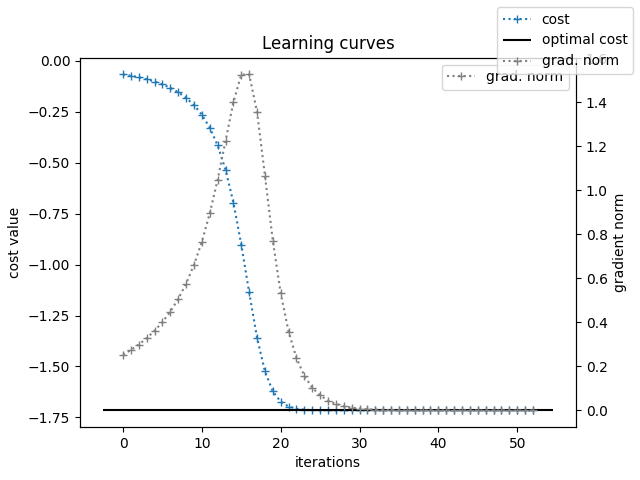

In [21]:
plt.close(4)
plt.figure(4)
plot_learning_curves(solver2.history['cost'], solver2.history['grad'], optimal_cost=minimum_f_val)
plt.legend()
plt.show()

## Optimization path
Let's also visualize the GD optimization path:

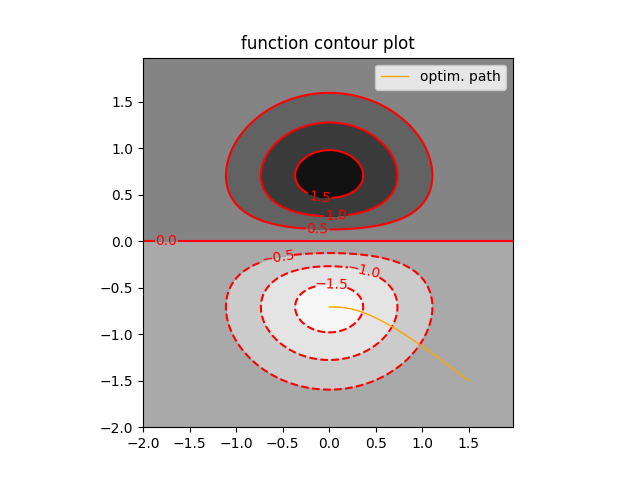

In [22]:
plt.close(5)
plt.figure(5)
plot_function(function)
plot_optim_path(solver2.history['theta'])
plt.show()

# Exercise 3 - fitting a linear model with GD
In this exercise you'll apply `GDminimizer` to a least-squares problem.

## Loading a regression dataset
First of all, we'll load a sample regression dataset. Here we take the classic ["California housing dataset"](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset), where the target is to predict house prices.

In [25]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
data_bunch = fetch_california_housing()

X, y = data_bunch.data, data_bunch.target
# Adding a column of ones to allow fitting of a constant parameter (the regression interecept)
X = np.concatenate([X,np.ones((X.shape[0],1))],axis=1)

# separating in train and validation
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2,random_state=42)

## Declaring least-squares cost
As seen before, in order to call a solver, it is necessary to define two `callable` elements:  
- a function providing the cost value for a given parameter theta
- a function providing the cost gradient value for a given parameter theta

**TODO**: complete the function declarations bellow so that they compute the least-squares cost and gradient given theta, X and y.

In [110]:
def lsCost(theta, X, y) -> float:
    # # TODO modify the function to return de cost value
    y_pred = np.dot(X, theta)
    # Compute the residuals
    residuals = y_pred - y
    # Compute the least-squares cost
    cost = np.mean(residuals**2)
    return cost

def lsGrad(theta, X, y) -> ArrayLike:
    # TODO modify the function to return the gradient value
    # Compute the predicted values using the linear model
    y_pred = np.dot(X, theta)
    # Compute the residuals
    residuals = y_pred - y
    # Compute the gradient of the least-squares cost
    gradient = 2 * np.dot(X.T, residuals) / X.shape[0]
    return gradient


## Calling GDminimizer

Our `GDminimizer` expects cost and gradient functions with only one argument (theta). We'll use new functions to generate versions of the cost and gradient specific to the training set.

In [106]:
def lsCostTrain(theta): return lsCost(theta, X_train, y_train)

def lsGradTrain(theta): return lsGrad(theta, X_train, y_train)


Now we can call the solver as done before, using the newly created functions.

**TODO**: complete the function call bellow to include cost and gradient functions just created

In [107]:
solver3 = GDminimizer()
# Pick a random initial theta
np.random.seed(1234)
theta0 = np.random.randn(X_train.shape[1])
# Call minimizer
# TODO complete the function call bellow
solver3.minimize(func=lsCostTrain,grad=lsGradTrain, 
                 theta0=theta0, step_size=1e-7,
                 max_iter=500, tol=1e-6)


{'theta': array([ 0.47140681, -1.19084801,  1.43255692, -0.31276324, -0.72053796,
         0.88707776,  0.85940986, -0.63638551,  0.01569637]),
 'cost': 12.21291013379738,
 'grad': array([ 0.56702488, -2.55347588,  3.00071523,  2.22662247, -1.01538129,
         1.70344117,  3.57075893, -2.75957511,  0.        ]),
 'n_iter': 500}

## Computing the optimum with the normal equations
As seen in the exercise class, it is possible to compute the solution to the linear least-squares problem directly from X and y.

**TODO**: using the equation derived in the exercise class, compute the optimum theta. Note: when computing a matrix inverse, use the method `np.linalg.pinv` which computes an approximate inverse even if the matrix is non-invertible.

In [108]:
# Computing the optimum with the normal equations and comparing to GD result
# TODO complete the optimum calculation bellow
def optimum(X, y): return np.dot(np.linalg.pinv(X), y)

optimum_val = optimum(X_train,y_train)
distance = np.linalg.norm(optimum_val - solver3.history['theta'][-1])
print(f'Distance to minimum: {distance}')
cost_gap = lsCostTrain(optimum_val) - solver3.history['cost'][-1]
print(f'Gap w.r.t. optimal cost: {cost_gap}')

Distance to minimum: 3.1297865545343106
Gap w.r.t. optimal cost: -7.402012896960079


## Learning curves
Note how the cost decreases very slowly after around 10 iterations.

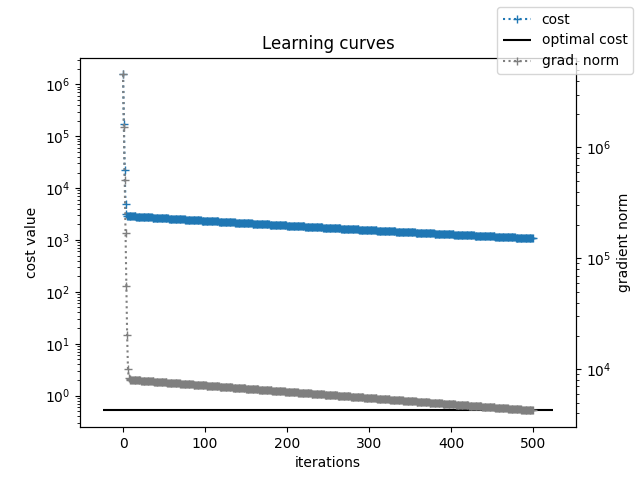

In [36]:
plt.close(6)
plt.figure(6)
ax, ax2 = plot_learning_curves(solver3.history['cost'], 
                               solver3.history['grad'],
                               optimal_cost=lsCostTrain(optimum_val))
ax.set_yscale('log')
ax2.set_yscale('log')
plt.show()

# Exercise 4 - rescaling features for better conditioning

## Standardizing features
As seen in class, GD may take a long time to converge when the cost function is poorly conditioned.
Conditionning is related to how fast the gradient varies along the different theta coordinates. If the variations are close to symmetric across all coordinates, we have better conditionning. One way to improve conditioning when working with multivariate data is to rescale all features so that they have similar variance. This way, gradient variations will be more simillar across coordinates. We can achieve so using `sklearn.preprocessing.StandardScaler`:

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Calling solver
If we call the solver on this rescaled data, we should be able to use a larger step size and converge much faster.

**TODO** change the step_size in the function call bellow until convergence is reached in less than 300 iterations.

In [96]:
solver4 = GDminimizer()
np.random.seed(1234)
theta0 = np.random.randn(X_train.shape[1])
# TODO change the argument step_size
solver4.minimize(lsCostTrain, lsGradTrain, theta0=theta0, 
                 step_size=0.282,
                 max_iter=500, tol=1e-6)

{'theta': array([ 0.8543803 ,  0.12254582, -0.29440496,  0.33925517, -0.00230785,
        -0.04082899, -0.8969342 , -0.86984676,  0.01569637]),
 'cost': 4.810897236842393,
 'grad': array([-2.76169968e-07, -3.25477840e-08,  5.39308397e-07, -4.59064577e-07,
        -9.37794614e-09,  1.01083025e-08, -4.65552377e-07, -4.31092041e-07,
         0.00000000e+00]),
 'n_iter': 299}

## Computing the optimum with the normal equations
Note how this time we are much closer to the optimal solution

In [97]:
# Computing the optimum with the normal equations and comparing to GD result
optimum_val = optimum(X_train, y_train)
distance = np.linalg.norm(optimum_val - solver4.history['theta'][-1])
print(f'Distance to minimum: {distance}')
cost_gap = lsCostTrain(optimum_val) - solver4.history['cost'][-1]
print(f'Gap w.r.t. optimal cost: {cost_gap}')


Distance to minimum: 0.015696375501094782
Gap w.r.t. optimal cost: -5.085709631202917e-12


## Learning curves

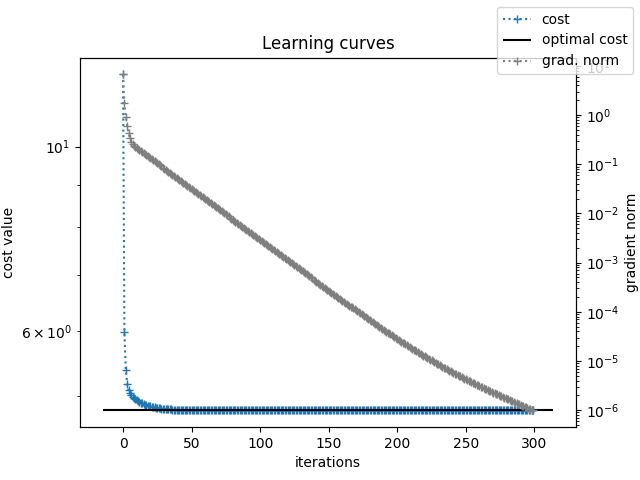

In [98]:
plt.close(7)
plt.figure(7)
ax, ax2 = plot_learning_curves(solver4.history['cost'], 
                               solver4.history['grad'],
                               optimal_cost=lsCostTrain(optimum_val))
ax.set_yscale('log')
ax2.set_yscale('log')
plt.show()


# Exercise 5 - SGD applied to linear regression
When the dataset is big or the cost function is computationally complex, iterations in GD can take a very long time to compute. In these cases, we often resort to using SGD.

In SGD, gradient estimates are quite noisy, and convergence to a near-zero gradient can take a very long time. However, in machine learning, we may content ourselves with a "good enough" solution in terms of generalization. This is monitored thanks to a heldout data partition, the validation data. In the loop bellow, cost value on the validation data is computed at every iteration. 

**TODO**: complete the code bellow to apply SGD to the housing dataset.

In [113]:
solver5 = GDminimizer()
# pick a random initial value for theta
np.random.seed(1234)
theta0 = np.random.randn(X_train.shape[1])

# set step size
step_size = 0.01

# Set batch size and compute number of batches
# TODO compute number of baches based on batch_size
batch_size = bs = 50
n_batches = X_train.shape[0] // batch_size

# initialize epoch count and set max epochs limit
n_epochs = 0
max_epochs = 100

# set max iter limit
max_iter = 1000

# set a convergence tolerance
tol = 1e-6

# loop through batches
# Boolean that is set to True when convergence is achieved
converged = False
# Monitor cost in validation set
val_curve = [lsCost(theta0, X_val, y_val)]
# TODO complete the while condition with pertinent stopping criteria
while (n_epochs < max_epochs):
    # TODO complete the code bellow to loop over the mini-batches of training samples
    for i in range(n_batches):
        # TODO complete the slicing indexes to X_train and y_train
        start = i * batch_size
        end = start + batch_size
        X_batch, y_batch = X_train[start:end], y_train[start:end]
        # TODO complete the functions bellow to use the mini-batch data
        def lsCostBatch(theta): return lsCost(theta,  X_batch, y_batch)
        def lsGradBatch(theta): return lsGrad(theta,  X_batch, y_batch)
        # One GD step is called
        solver5.step(lsCostBatch, lsGradBatch, theta0,
                     step_size=step_size, warm_start=True)
        # Checking gradient for convergence
        # TIP since gradients are noisy, we can look at a moving average of recent values to check convergence
        past_grad_avg_norm = np.mean(
            np.linalg.norm(solver5.history['grad'][-10:], axis=1))
        if (past_grad_avg_norm < tol):
            converged = True
            break

        # Store validation cost
        val_curve.append(lsCost(solver5.state['theta'], X_val, y_val))
    n_epochs += 1

solver5.state,converged

({'theta': array([ 0.82319561,  0.11685757, -0.29120886,  0.32581481,  0.04485811,
         -0.00781436, -0.93330028, -0.86190026,  0.01569637]),
  'cost': 5.4600857326250525,
  'grad': array([-1.56867786,  0.46518943, -0.1881618 ,  0.44861049,  0.22023464,
          0.08109715,  0.48426685, -0.34941918,  0.        ]),
  'n_iter': 33000},
 False)

## Learning curves
Note how noisy the cost and gradient curves are.

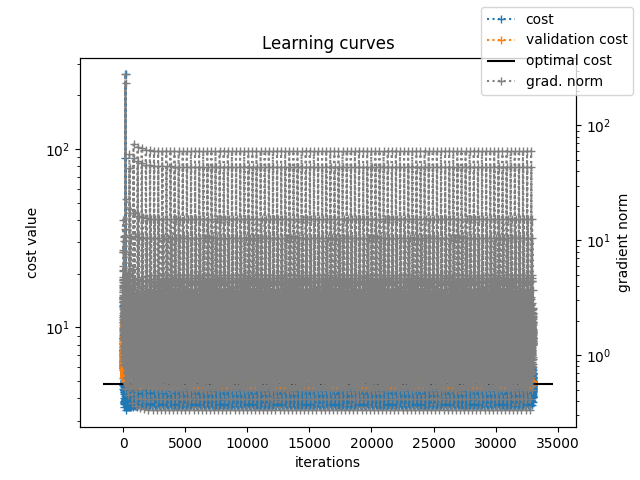

In [114]:
plt.close(8)
plt.figure(8)
ax, ax2 = plot_learning_curves(solver5.history['cost'], solver5.history['grad'],
                               val_curve=val_curve, optimal_cost=lsCostTrain(optimum_val))
ax.set_yscale('log')
ax2.set_yscale('log')
plt.show()


Let's redo the plot but smoothing the curves with a moving average (the smooth parameter determines the window size as a fraction of the total series lenght). This way we can filter the more intense oscilations (high frequency noise).

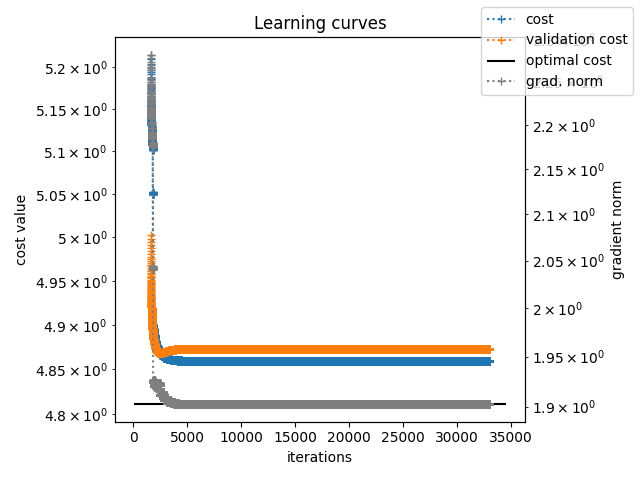

In [115]:
plt.close(9)
plt.figure(9)
ax, ax2 = plot_learning_curves(solver5.history['cost'], solver5.history['grad'],
                               val_curve,
                               optimal_cost=lsCostTrain(optimum_val),
                               smooth=0.05)
ax.set_yscale('log')
ax2.set_yscale('log')
plt.tight_layout()
plt.show()


Note that the gradient norms oscilate a lot and do not seem to be converging to zero anytime soon. Nonetheless, we can see the validation cost is decreasing fast at the beggining and slows down after 700 iterations, approaching the the optimal training cost. In machine learning in general, it is common to stop SGD if the validation performance ceases to improve, kepping as a solution the theta value leading to the best validation score so far.

**TODO**: get the theta value leading to the best validation score so far

In [117]:
# TODO complete the line bellow to get the theta leading to the best validation score so far
best_val_cost_idx = np.argmin(val_curve)
best_theta_sgd = solver5.history['theta'][best_val_cost_idx]
distance = np.linalg.norm(optimum_val - best_theta_sgd)
print(f'Distance to training minimum: {distance}')

Distance to training minimum: 0.2167447388710064
